# Import section

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
import datetime

In [2]:
%load_ext tensorboard

In [3]:
print(f"tensorflow version: {tf.__version__}")
tf.test.is_built_with_gpu_support()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version: 2.3.0
Num GPUs Available:  1


# Data loading section

In [28]:
labels_file_path = os.path.join(os.getcwd(), 'input', 'monkey_labels.txt')
labels_data = pd.read_csv(labels_file_path)
original_train_ds_len = sum(labels_data.iloc[:,3])
original_val_ds_len = sum(labels_data.iloc[:,4])
CLASSES_NUMBER = len(labels_data)


train_data_dir_path = os.path.join(os.getcwd(), 'input', 'training/training')
validation_data_dir_path = os.path.join(os.getcwd(), 'input', 'validation/validation')

BATCH_SIZE = 16
IMG_HEIGHT = 150
IMG_WIDTH = 150

loading_image_gen = tf.keras.preprocessing.image.ImageDataGenerator()                                                        
train_data_gen = loading_image_gen.flow_from_directory(directory=train_data_dir_path,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode='categorical',
                                                       batch_size=BATCH_SIZE)

valid_data_gen = loading_image_gen.flow_from_directory(directory=validation_data_dir_path,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode='categorical',
                                                       batch_size=BATCH_SIZE)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


### Inspect data

In [29]:
# Auxiliary functions
class_id_to_label = dict()
for i in range(CLASSES_NUMBER):
    class_id_to_label[i] = labels_data.iloc[i,2].replace(' ', '')
    
def onehot_to_label(one_hot_label):
    return class_id_to_label[np.argmax(one_hot_label)]

def show_example(image, label):
    plt.figure(figsize=(10, 10))
    plt.imshow(image.astype("uint8"))
    plt.title(onehot_to_label(label))
    plt.axis("off")

def show_batch(images_batch, labels_batch):
    examples_no = images_batch.shape[0]
    grid_width = np.ceil(np.sqrt(examples_no))
    plt.figure(figsize=(10, 10))
    for i in range(examples_no):
        image = images_batch[i]
        label = labels_batch[i]
        ax = plt.subplot(grid_width, grid_width, i+1)
        plt.imshow(image.astype("uint8"))
        plt.title(onehot_to_label(label))
        plt.axis("off")

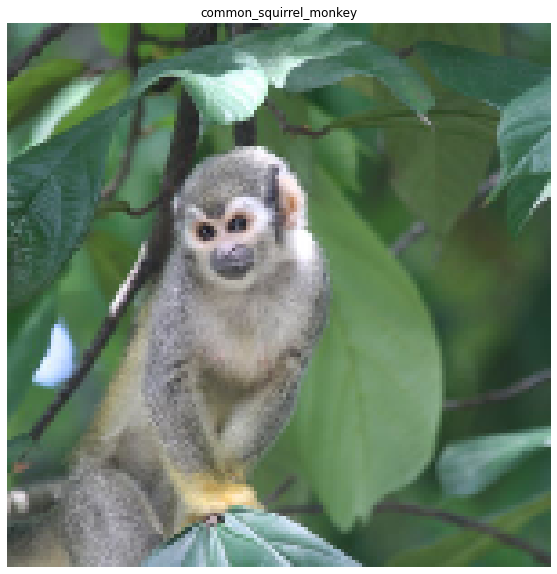

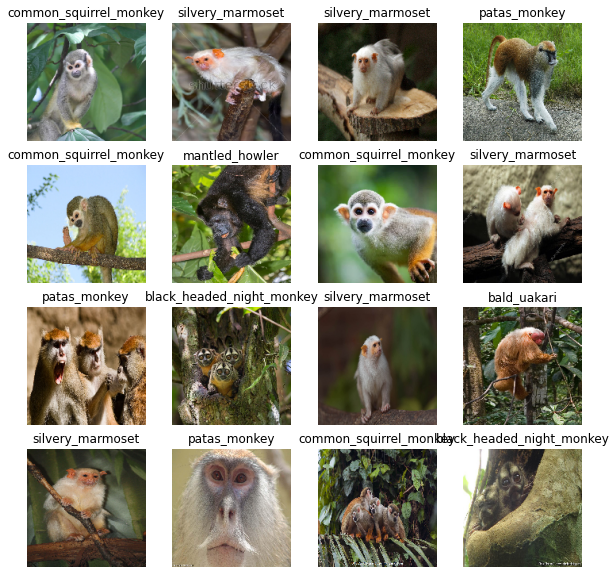

In [30]:
images_batch, labels_batch = next(train_data_gen)
show_example(images_batch[0], labels_batch[0])
show_batch(images_batch, labels_batch)

In [31]:
%%time
print(next(iter(train_data_gen))[0].shape)
print(next(iter(train_data_gen))[1].shape)

(16, 150, 150, 3)
(16, 10)
CPU times: user 568 ms, sys: 17 µs, total: 568 ms
Wall time: 566 ms


### Convert data into numpy array

In [32]:
%%time
# data generators to numpy array conversion

train_dataset = tf.data.Dataset.from_generator(lambda: train_data_gen,
                               output_types=(tf.float32, tf.float32),
                               output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, 3), (None, CLASSES_NUMBER))
                                              ).unbatch().take(1098)
np_train_dataset = next(train_dataset.batch(1098).as_numpy_iterator())

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_data_gen,
                               output_types=(tf.float32, tf.float32),
                               output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, 3), (None, CLASSES_NUMBER))
                                              ).unbatch().take(272)
np_valid_dataset = next(valid_dataset.batch(272).as_numpy_iterator())

CPU times: user 26.7 s, sys: 473 ms, total: 27.2 s
Wall time: 27.2 s


### Data Augmentation

In [33]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_image_gen.fit(np_train_dataset[0])

train_generator = train_image_gen.flow(
    np_train_dataset[0],
    np_train_dataset[1],
    batch_size=BATCH_SIZE,
    shuffle=True)

test_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    featurewise_center=True,
    featurewise_std_normalization=True)

test_image_gen.fit(np_train_dataset[0])

validation_generator = test_image_gen.flow(
    np_valid_dataset[0],
    np_valid_dataset[1],
    batch_size=BATCH_SIZE,
    shuffle=True)

In [34]:
# # data generators to tf.data.Dataset conversion
# train_dataset = tf.data.Dataset.from_generator(lambda: train_data_gen,
#                                output_types=(tf.float32, tf.float32),
#                                output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, 3), (None, CLASSES_NUMBER))
#                                               ).prefetch(16)

# valid_dataset = tf.data.Dataset.from_generator(lambda: valid_data_gen,
#                                output_types=(tf.float32, tf.float32),
#                                output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, 3), (None, CLASSES_NUMBER))
#                                               ).prefetch(16)

In [35]:
def simple_statistics(dataset):
    features = dataset[0]
    print(f"features shape: {features.shape}")
    print('Features:')
    print(f"Mean: {np.mean(features)}")
    print(f"Std: {np.std(features)}")
    print(f"Min: {np.min(features)}")
    print(f"Max: {np.max(features)}")
    
    labels = dataset[1]
    print('Labels:')
    print(f"Labels shape: {labels.shape}")
    output_notebook()

    labels = list(class_id_to_label.values())
    class_representation = np.sum(dataset[1][:,:], axis=0)/len(dataset[1])

    p = figure(x_range=labels, plot_height=250, title="Class representation",
               toolbar_location=None, tools="")

    p.vbar(x=labels, top=class_representation, width=0.9)

    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    show(p)
    

In [36]:
# Statistics of tf.dataDataset(s)
# simple_statistics(np_train_dataset)
# simple_statistics(np_valid_dataset)
# simple_statistics(np_test_dataset)

# Model architecture section

In [ ]:
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Transfer learning with Xception network
x = tf.keras.applications.xception.preprocess_input(inputs)
xception = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
xception.trainable = False
x = xception(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# # Transfer learning with Xception network
# x = tf.keras.applications.xception.preprocess_input(inputs)
# xception = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet')
# xception.trainable = False
# x = xception(x)
# x1 = tf.keras.layers.GlobalAveragePooling2D()(x)

# # Transfer learning with Vgg network
# x = tf.keras.applications.vgg19.preprocess_input(inputs)
# vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
# vgg19.trainable = False
# x = vgg19(x)
# x2 = tf.keras.layers.GlobalAveragePooling2D()(x)

# # Transfer learning with mobile net v2 network
# x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
# mobilenet_v2 = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
# mobilenet_v2.trainable = False
# x = mobilenet_v2(x)
# x3 = tf.keras.layers.GlobalAveragePooling2D()(x)

# # Transfer learning with inception_resnet_v2 
# x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
# inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')
# inception_resnet_v2.trainable = False
# x = inception_resnet_v2(x)
# x4 = tf.keras.layers.GlobalAveragePooling2D()(x)

# x = tf.keras.layers.Concatenate()([x1, x2, x3, x4])

# Dense layer on the top
# x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0))(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(rate=0.2)(x)

outputs = tf.keras.layers.Dense(CLASSES_NUMBER, activation='softmax', name='output')(x)

model = tf.keras.models.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

# Model from-scratch

In [38]:
reg_factor = 0.03
dropout_rate = 0.2
model = tf.keras.Sequential([
    tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
#     tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

# tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_24 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 36, 36, 32)       

In [49]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# Model training section

In [ ]:
model.save(f"/kaggle/working/model_{datetime.datetime.now().strftime('%Y_%m_%d__%H_%M_%S')}")

In [39]:
log_dir = os.path.join(os.getcwd(), 'logs/fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, update_freq='epoch')
model_path = os.path.join(os.getcwd(), 'model')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(model_path, save_freq='epoch')

In [63]:
# !rm -r /kaggle/working/logs

In [64]:
# Training with tf.data.Dataset from generator
# model.fit(train_dataset,
#           epochs=10,
#           steps_per_epoch=32,
#           validation_data=test_dataset,
#           validation_steps=8,
#           callbacks=[tensorboard_callback]
#          )

In [65]:
# # Training with numpy arrays
# history = model.fit(x=np_train_dataset[0], y=np_train_dataset[1],
#                     validation_data=np_valid_dataset,
#                     shuffle=True,
#                     batch_size=32, epochs=100,
#                    callbacks=[tensorboard_callback])

In [47]:
# Training with data generators
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=200,
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/200
69/69 [==============================] - 4s 64ms/step - loss: 2.3673 - accuracy: 0.9927 - val_loss: 3.3914 - val_accuracy: 0.6912
Epoch 2/200
69/69 [==============================] - 4s 64ms/step - loss: 2.3467 - accuracy: 0.9909 - val_loss: 3.3050 - val_accuracy: 0.7059
Epoch 3/200
69/69 [==============================] - 4s 64ms/step - loss: 2.3293 - accuracy: 0.9936 - val_loss: 3.3670 - val_accuracy: 0.6912
Epoch 4/200
69/69 [==============================] - 4s 63ms/step - loss: 2.3055 - accuracy: 0.9945 - val_loss: 3.3059 - val_accuracy: 0.6985
Epoch 5/200
69/69 [==============================] - 4s 63ms/step - loss: 2.2813 - accuracy: 0.9945 - val_loss: 3.2665 - val_accuracy: 0.7132
Epoch 6/200
69/69 [==============================] - 4s 64ms/step - loss: 2.2719 - accuracy: 0.9918 - val_loss: 3.4162 - val_accuracy: 0.6618
Epoch 7/200
69/69 [==============================] - 4s 64ms/step - loss: 2.2666 - accuracy: 0.9900 - val_loss: 3.2995 - val_accuracy: 0.7059
Epoch 

In [62]:
reg_factor = 0.001
dropout_rate = 0.1
model2 = tf.keras.Sequential([
    tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
# Training with data generators
history = model2.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/20
69/69 [==============================] - 5s 68ms/step - loss: 8.1537 - accuracy: 0.3424 - val_loss: 5.8030 - val_accuracy: 0.2243
Epoch 2/20
69/69 [==============================] - 4s 65ms/step - loss: 5.5649 - accuracy: 0.4754 - val_loss: 6.4689 - val_accuracy: 0.2904
Epoch 3/20
69/69 [==============================] - 4s 65ms/step - loss: 4.5036 - accuracy: 0.5583 - val_loss: 6.5784 - val_accuracy: 0.4044
Epoch 4/20
69/69 [==============================] - 4s 64ms/step - loss: 4.1340 - accuracy: 0.5993 - val_loss: 6.1264 - val_accuracy: 0.3125
Epoch 5/20
69/69 [==============================] - 4s 64ms/step - loss: 3.6716 - accuracy: 0.6585 - val_loss: 4.7171 - val_accuracy: 0.4706
Epoch 6/20
69/69 [==============================] - 4s 65ms/step - loss: 3.2821 - accuracy: 0.7049 - val_loss: 4.4777 - val_accuracy: 0.5147
Epoch 7/20
69/69 [==============================] - 4s 64ms/step - loss: 3.1567 - accuracy: 0.7231 - val_loss: 3.7408 - val_accuracy: 0.6066
Epoch 8/20
69

In [68]:
reg_factor = 0.0
dropout_rate = 0.25
model3 = tf.keras.Sequential([
    tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_factor)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
# Training with data generators
history = model3.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=200,
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/200
69/69 [==============================] - 4s 65ms/step - loss: 0.5213 - accuracy: 0.8142 - val_loss: 0.9713 - val_accuracy: 0.7132
Epoch 2/200
69/69 [==============================] - 4s 64ms/step - loss: 0.5261 - accuracy: 0.8087 - val_loss: 1.0523 - val_accuracy: 0.6875
Epoch 3/200
69/69 [==============================] - 4s 64ms/step - loss: 0.5246 - accuracy: 0.8179 - val_loss: 0.9997 - val_accuracy: 0.7132
Epoch 4/200
69/69 [==============================] - 4s 65ms/step - loss: 0.5948 - accuracy: 0.7869 - val_loss: 1.0506 - val_accuracy: 0.6985
Epoch 5/200
69/69 [==============================] - 4s 64ms/step - loss: 0.5422 - accuracy: 0.8106 - val_loss: 1.1062 - val_accuracy: 0.7169
Epoch 6/200
69/69 [==============================] - 4s 64ms/step - loss: 0.5034 - accuracy: 0.8361 - val_loss: 1.0060 - val_accuracy: 0.7426
Epoch 7/200
69/69 [==============================] - 4s 65ms/step - loss: 0.4839 - accuracy: 0.8315 - val_loss: 1.0614 - val_accuracy: 0.7132
Epoch 

# Tensorboard

In [15]:
%tensorboard --logdir /home/jan/kaggle_competitions/monkeys/logs/fit

# Model analysis section

In [72]:
def feature_maps(model, example):
    if len(example.shape) == 3:
        example = np.expand_dims(example, axis=0)
    elif len(example.shape) != 4:
        raise "Invalid example shape (should be 3 or 4)"
    model.trainable = False
    # Find all conv layers
    for layer in model.layers:
        feature_maps = layer(example)
        if 'conv' in layer.name.lower():
            print(layer.name)
            filters_no = feature_maps.shape[3]
            ix=1
            plt.figure(figsize=(30, 20))
            for i in range(filters_no):
                feature_map = feature_maps.numpy()[0, :, :, i]
                ax = plt.subplot(np.ceil(np.sqrt(filters_no)), np.ceil(np.sqrt(filters_no)), ix)
                ax.set_xticks([])
                ax.set_yticks([])
                feature_map_min, feature_map_max = feature_map.min(), feature_map.max()
#                 print(feature_map_min)
#                 print(feature_map_max)
                feature_map = (feature_map - feature_map_min) / (feature_map_max - feature_map_min)
                feature_map = feature_map * 255
                plt.imshow(feature_map, cmap='gray')
                ix += 1
            plt.show()
        example = feature_maps
    model.trainable = True

First model feature maps analysis

conv2d_24


/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/jan/.local/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/jan/.local/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/jan/.local/lib/python3.7/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/jan/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


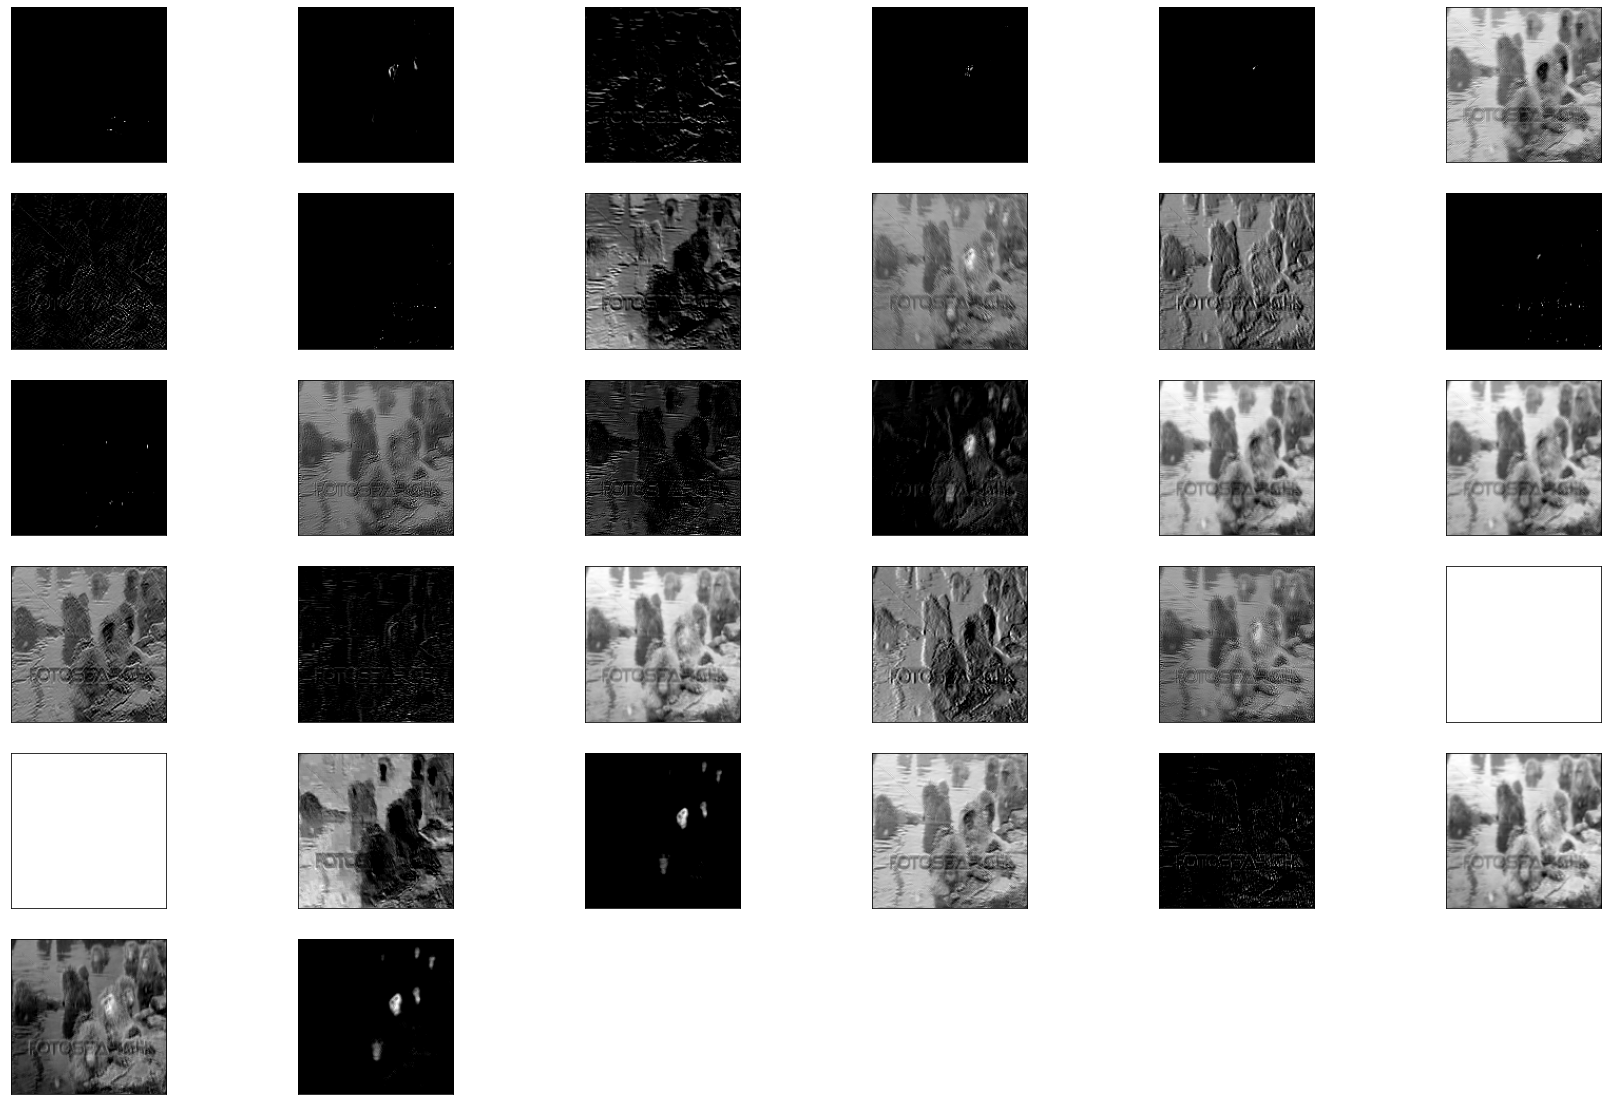

conv2d_25


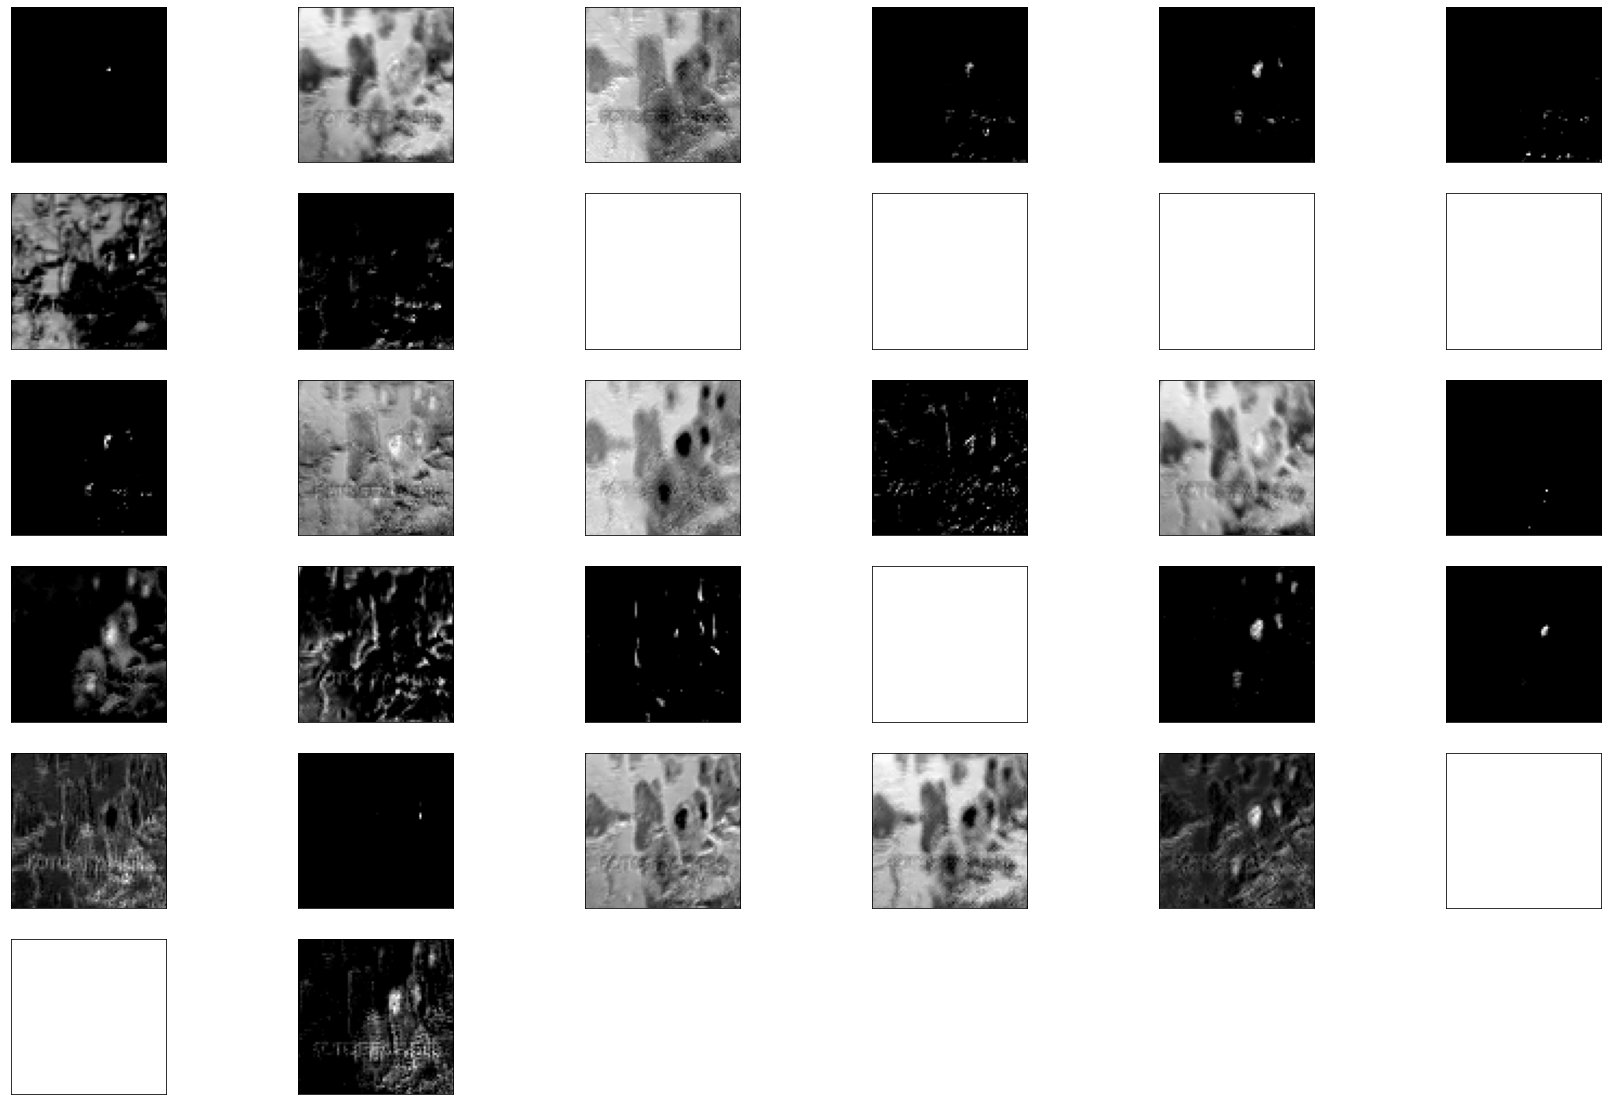

conv2d_26


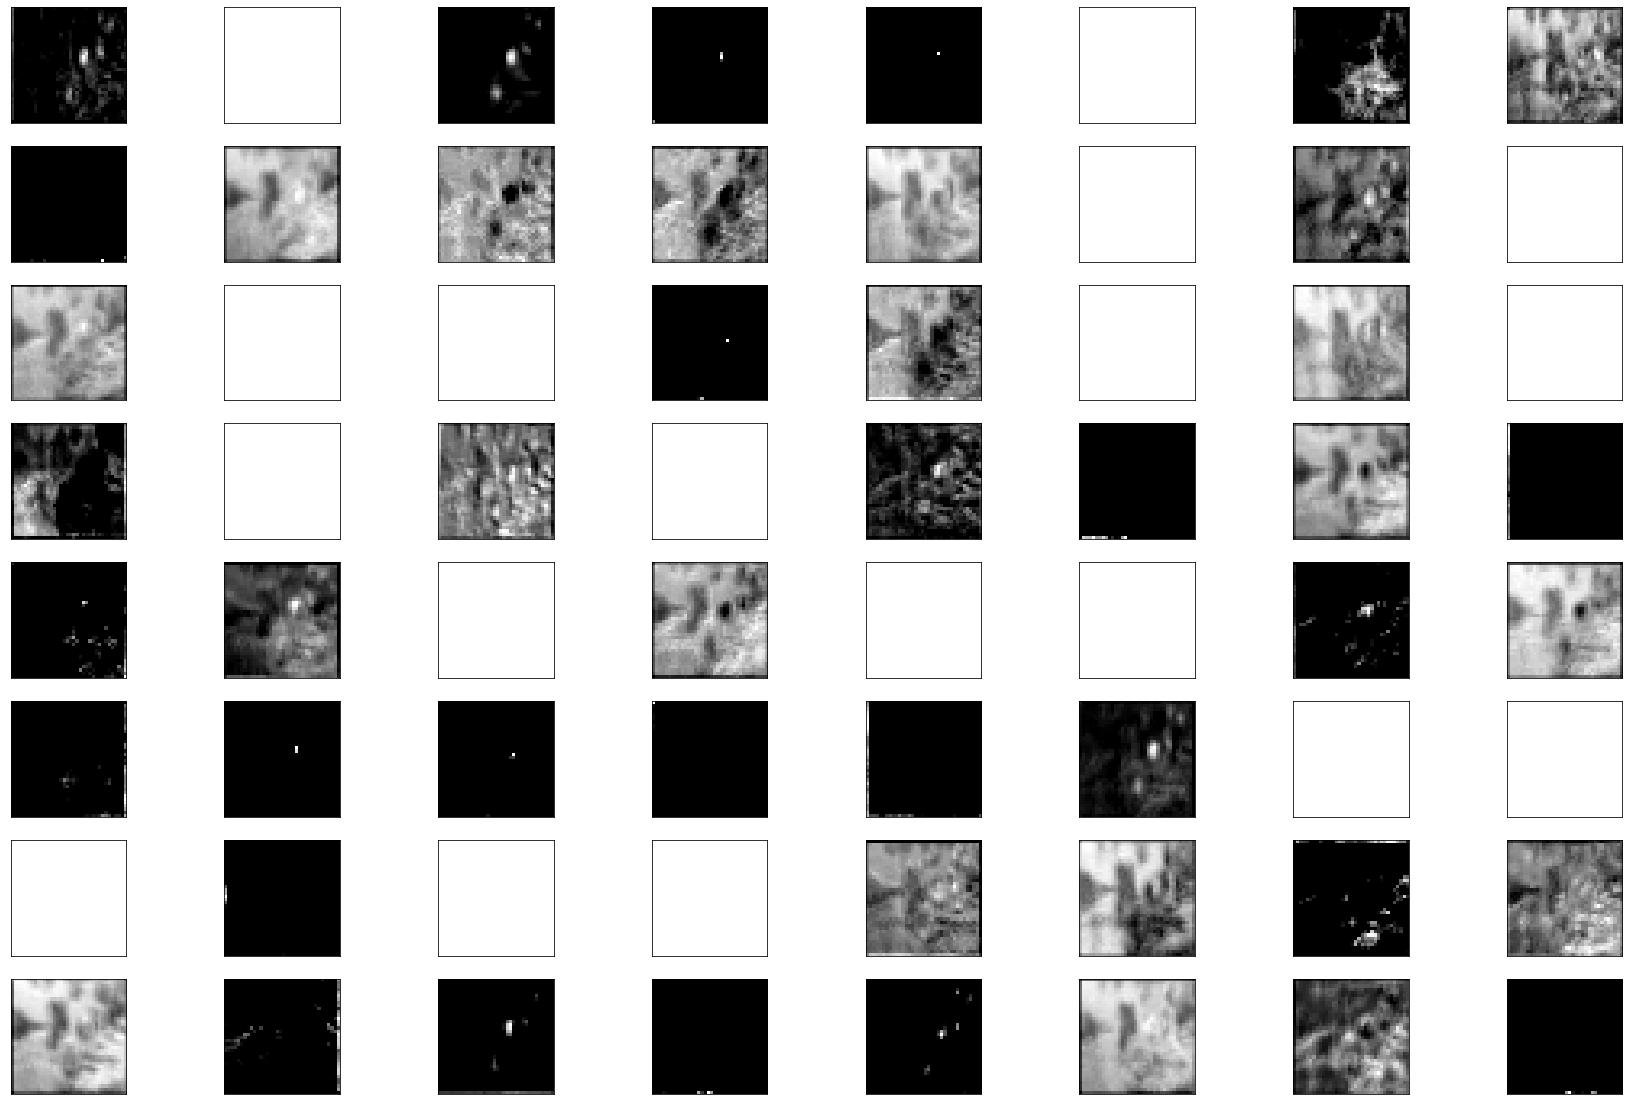

conv2d_27


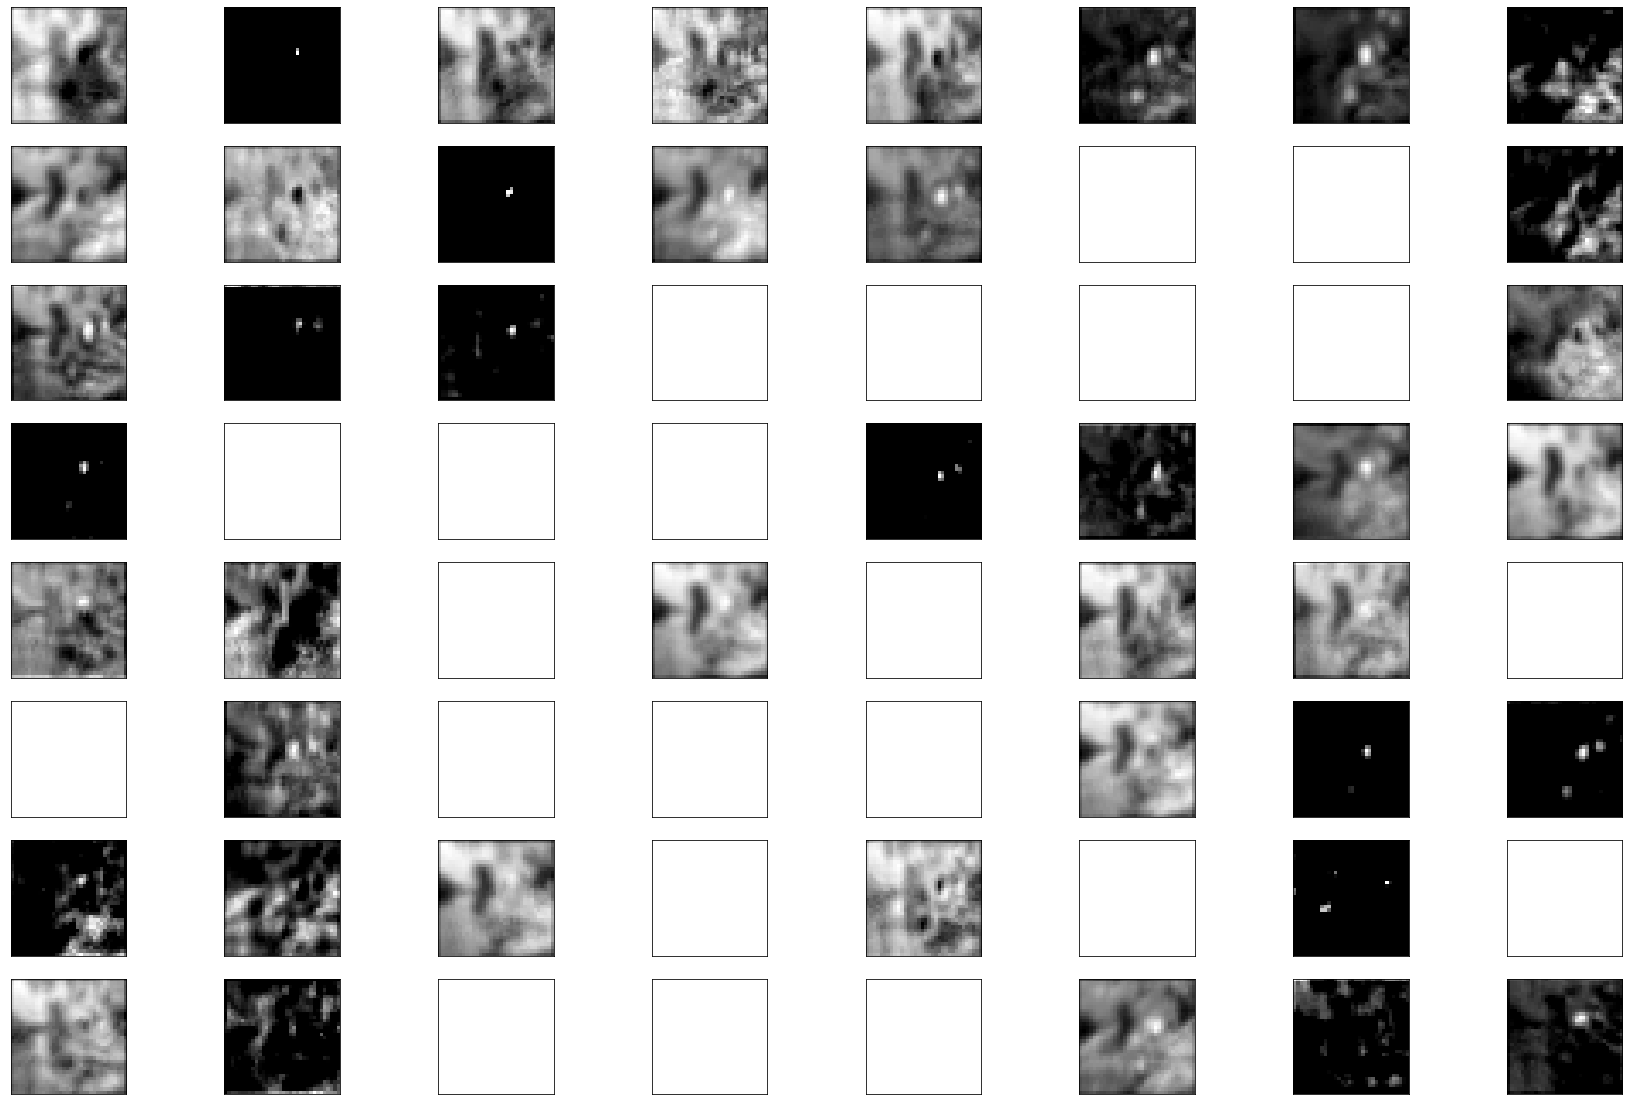

In [73]:
example = np_train_dataset[0][0]
feature_maps(model, example)

# Second model feature maps analysis

conv2d_52


/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


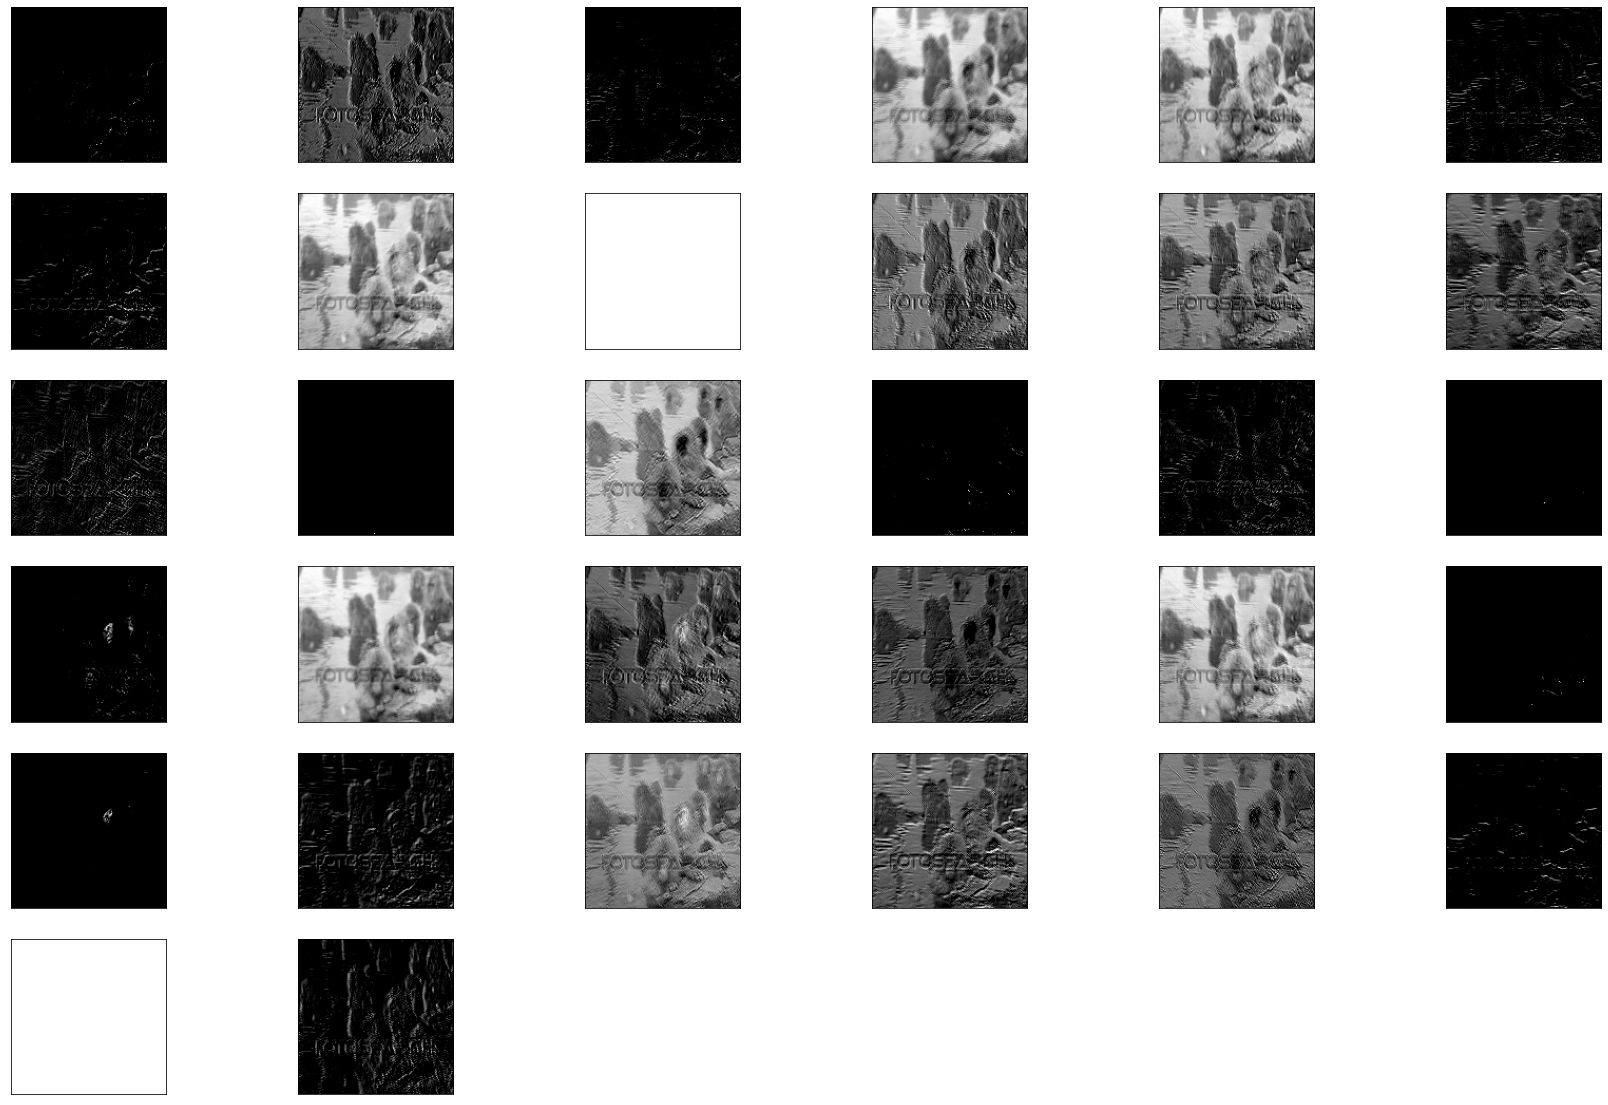

conv2d_53


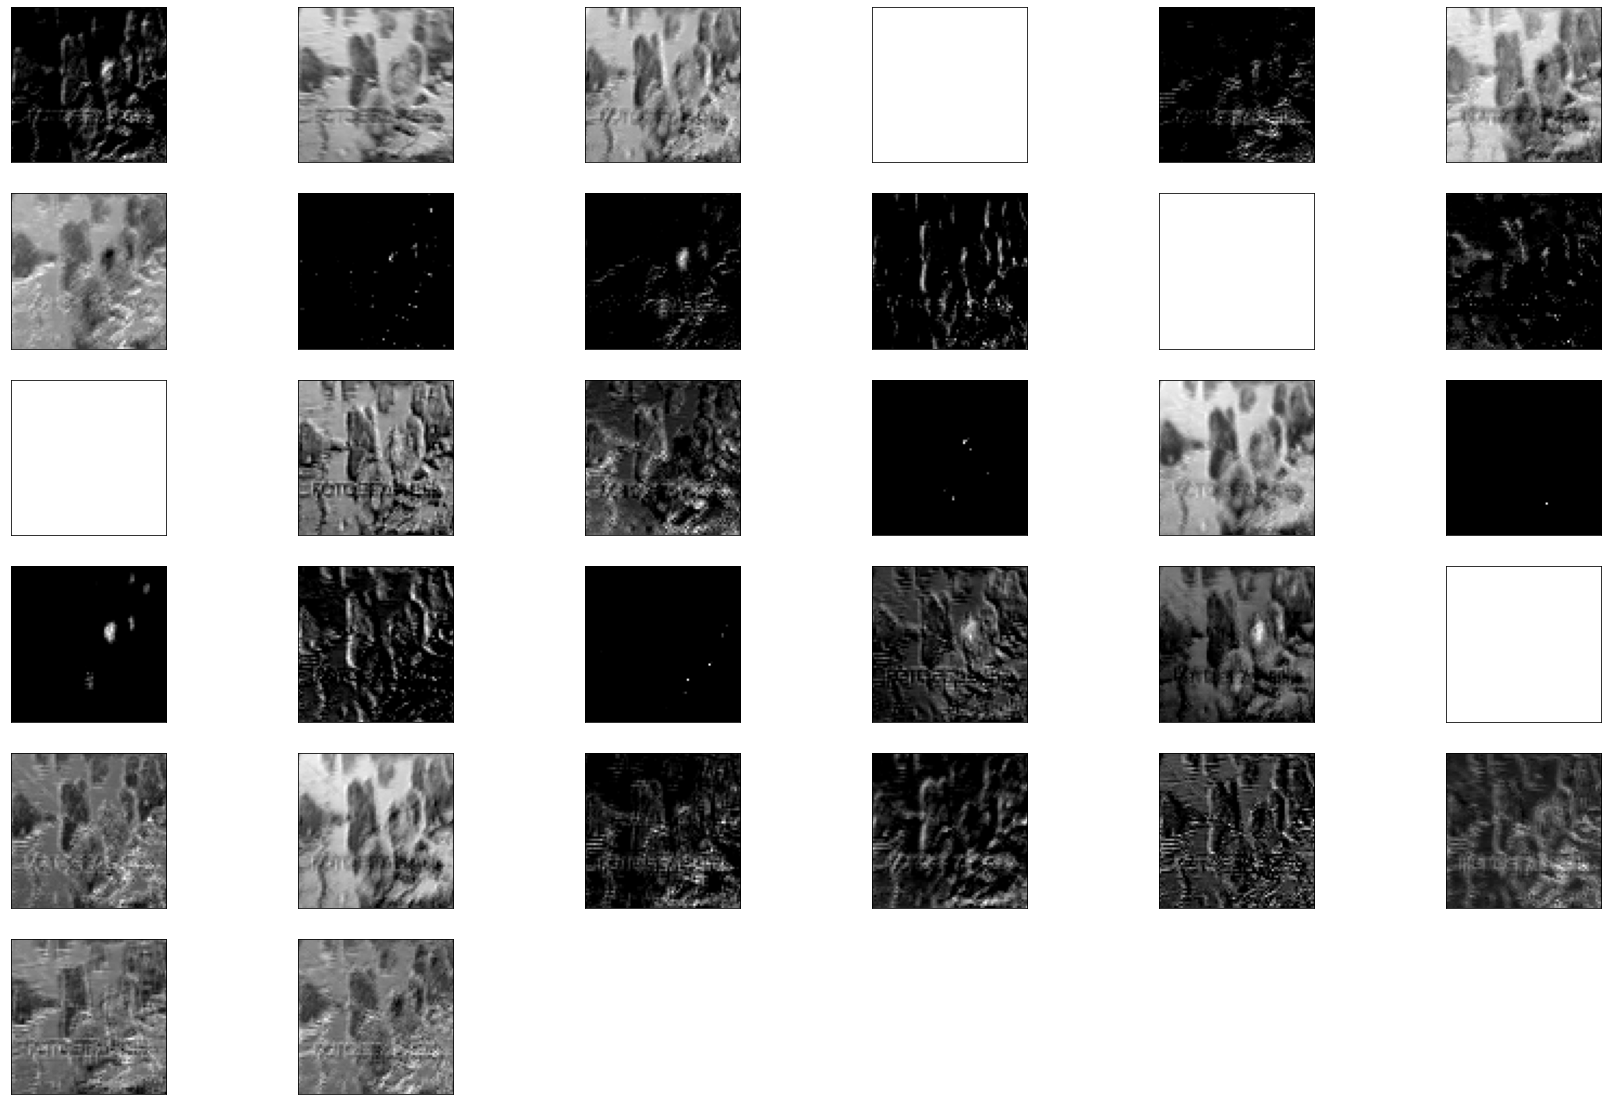

conv2d_54


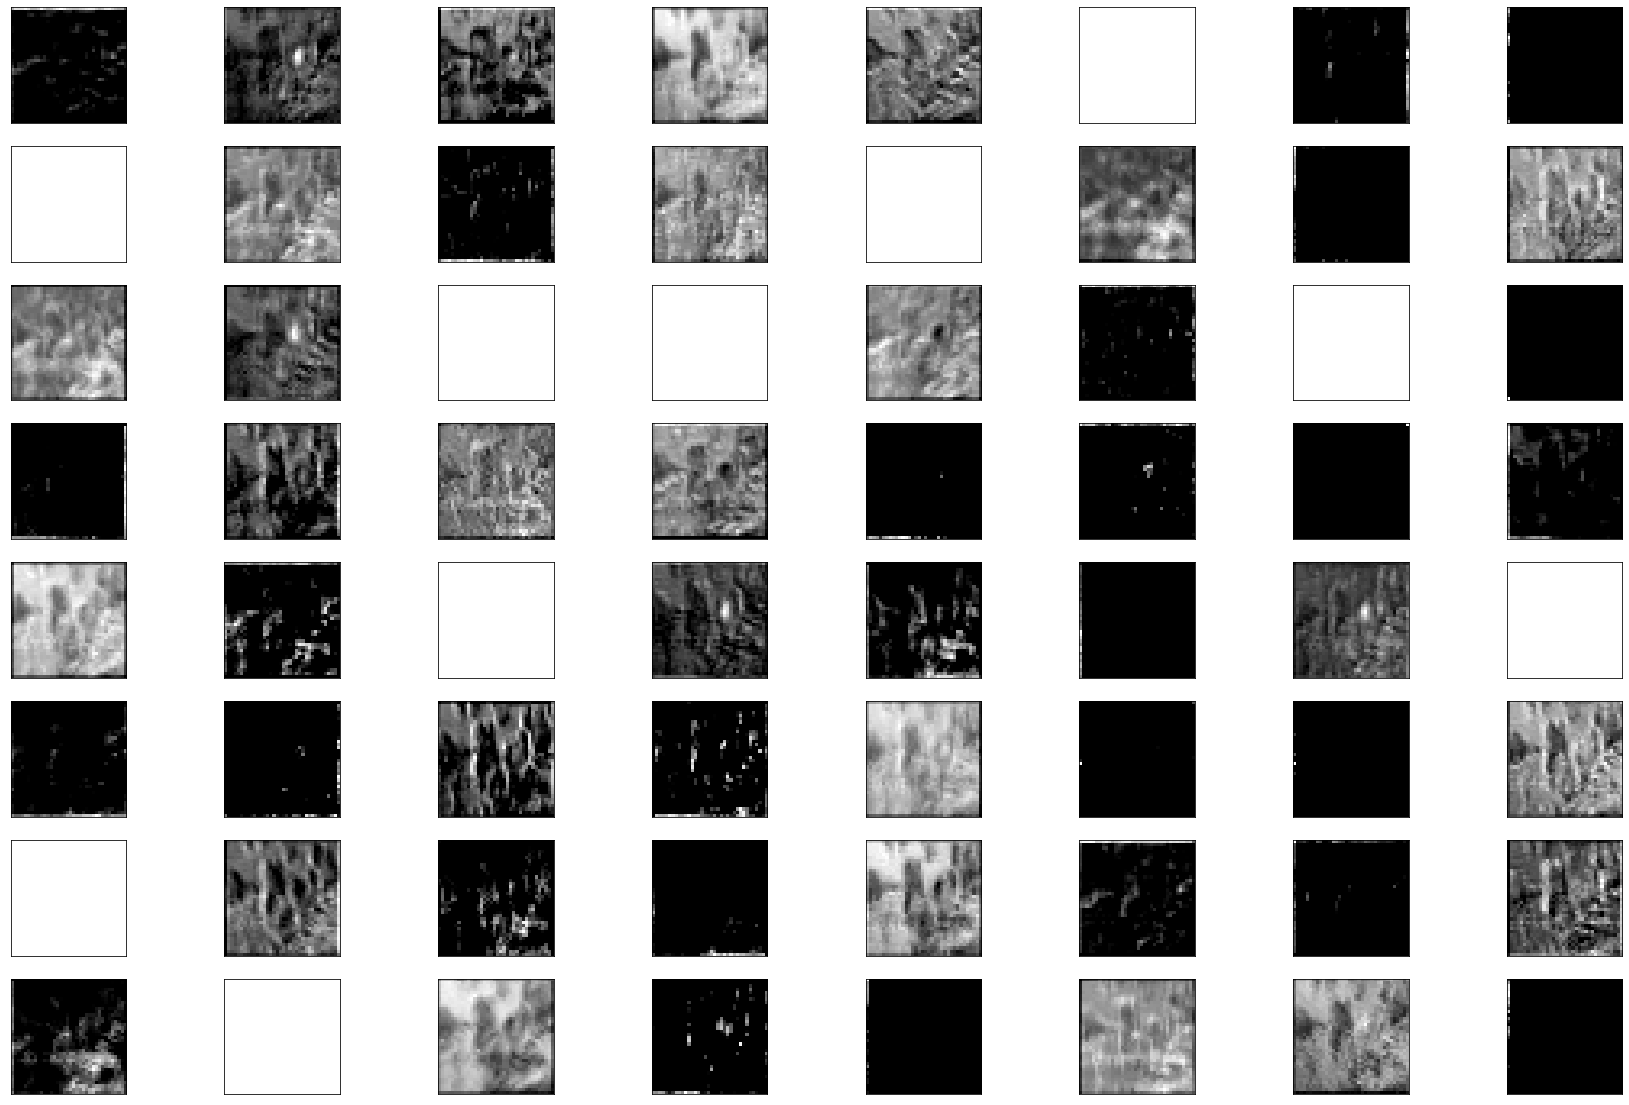

conv2d_55


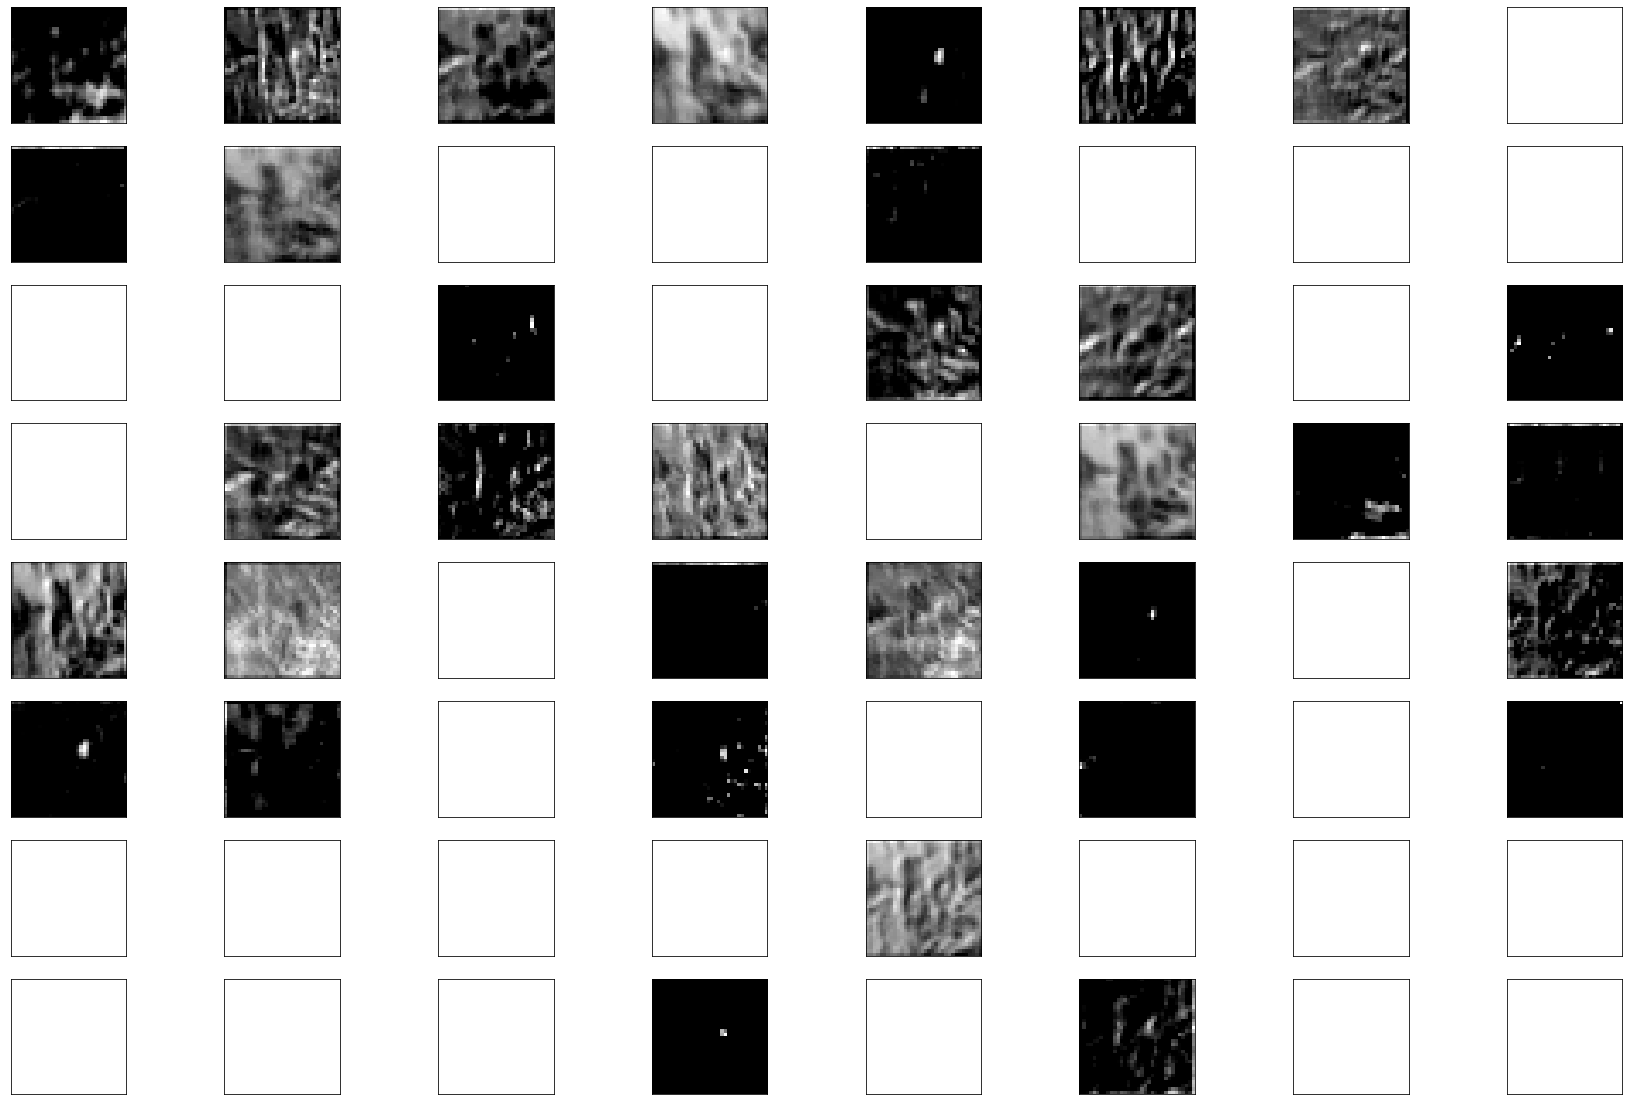

In [75]:
example = np_train_dataset[0][0]
feature_maps(model2, example)

# third model feature maps analysis

conv2d_64


/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


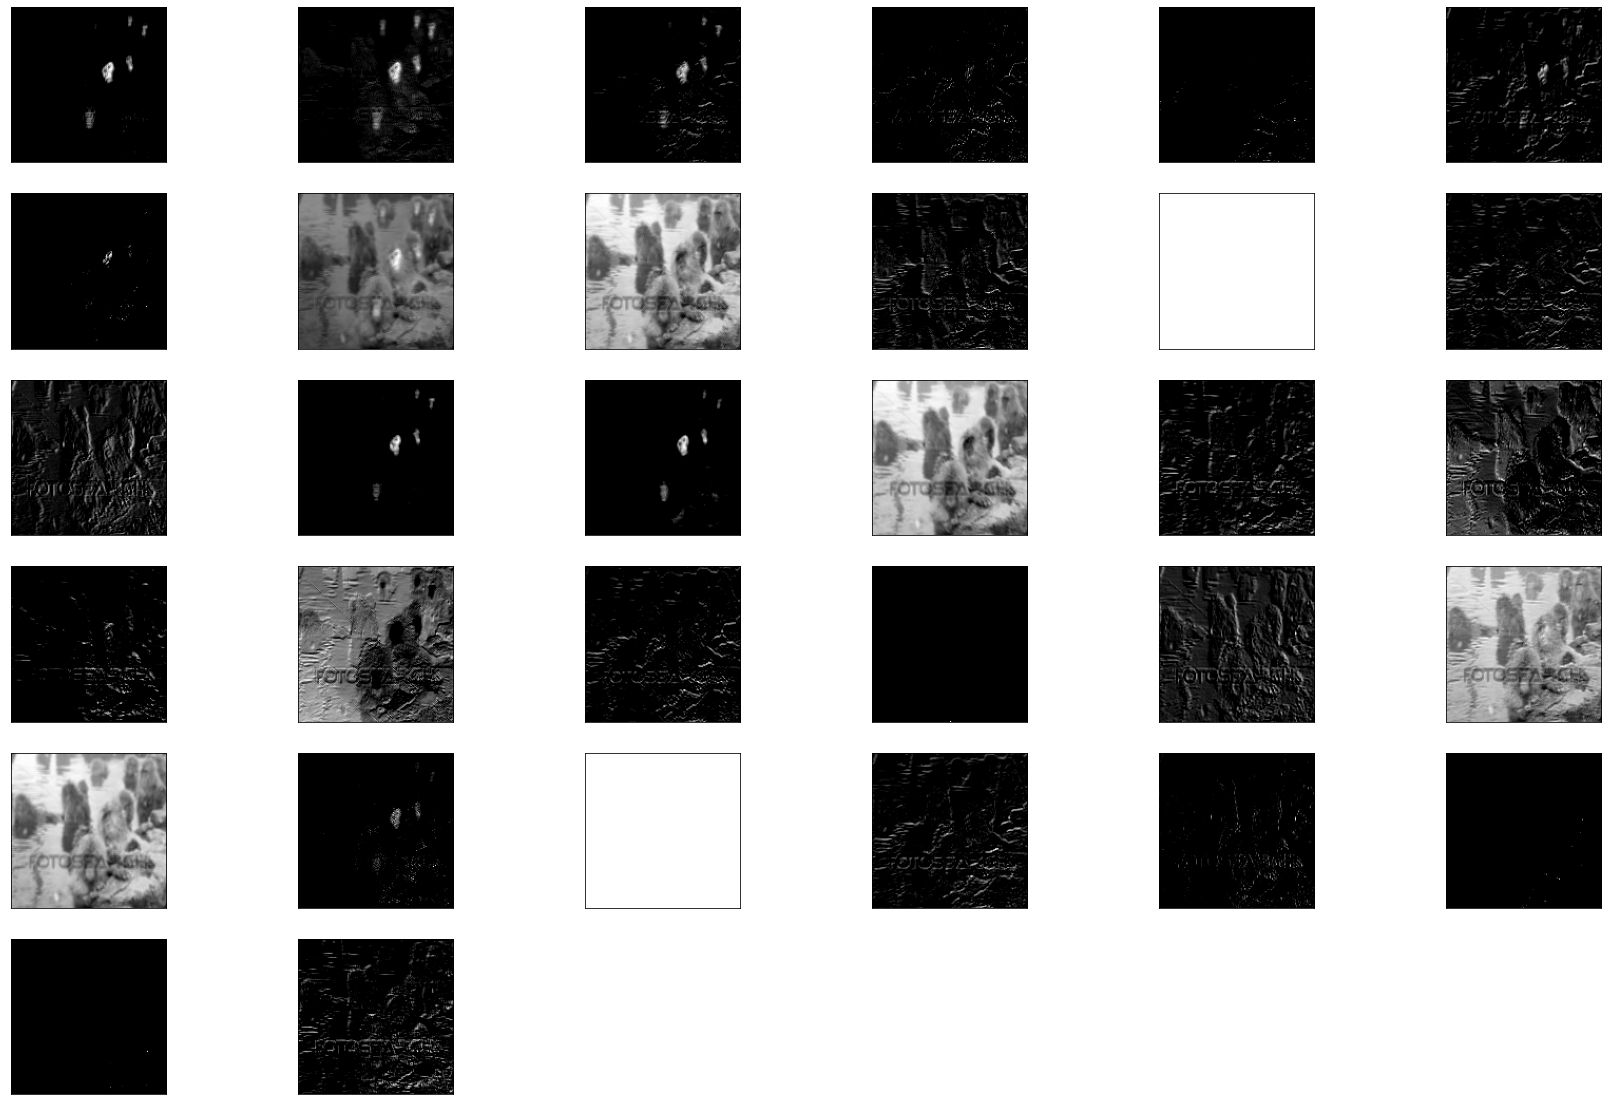

conv2d_65


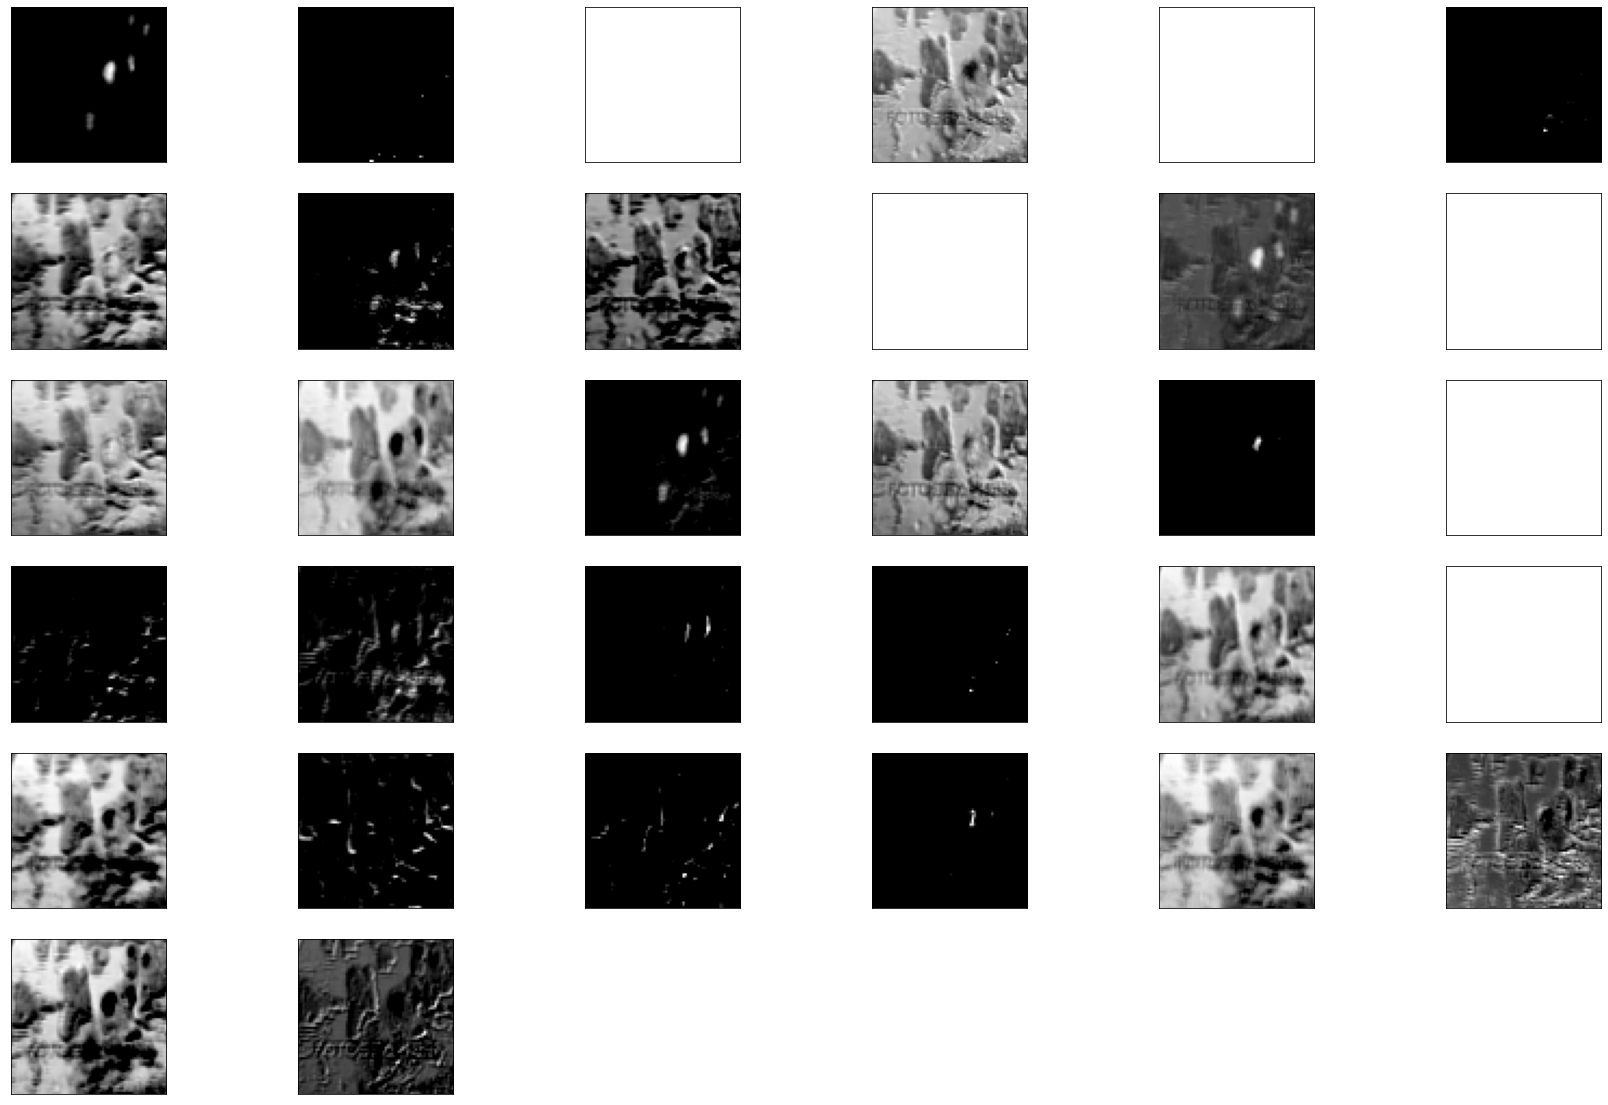

conv2d_66


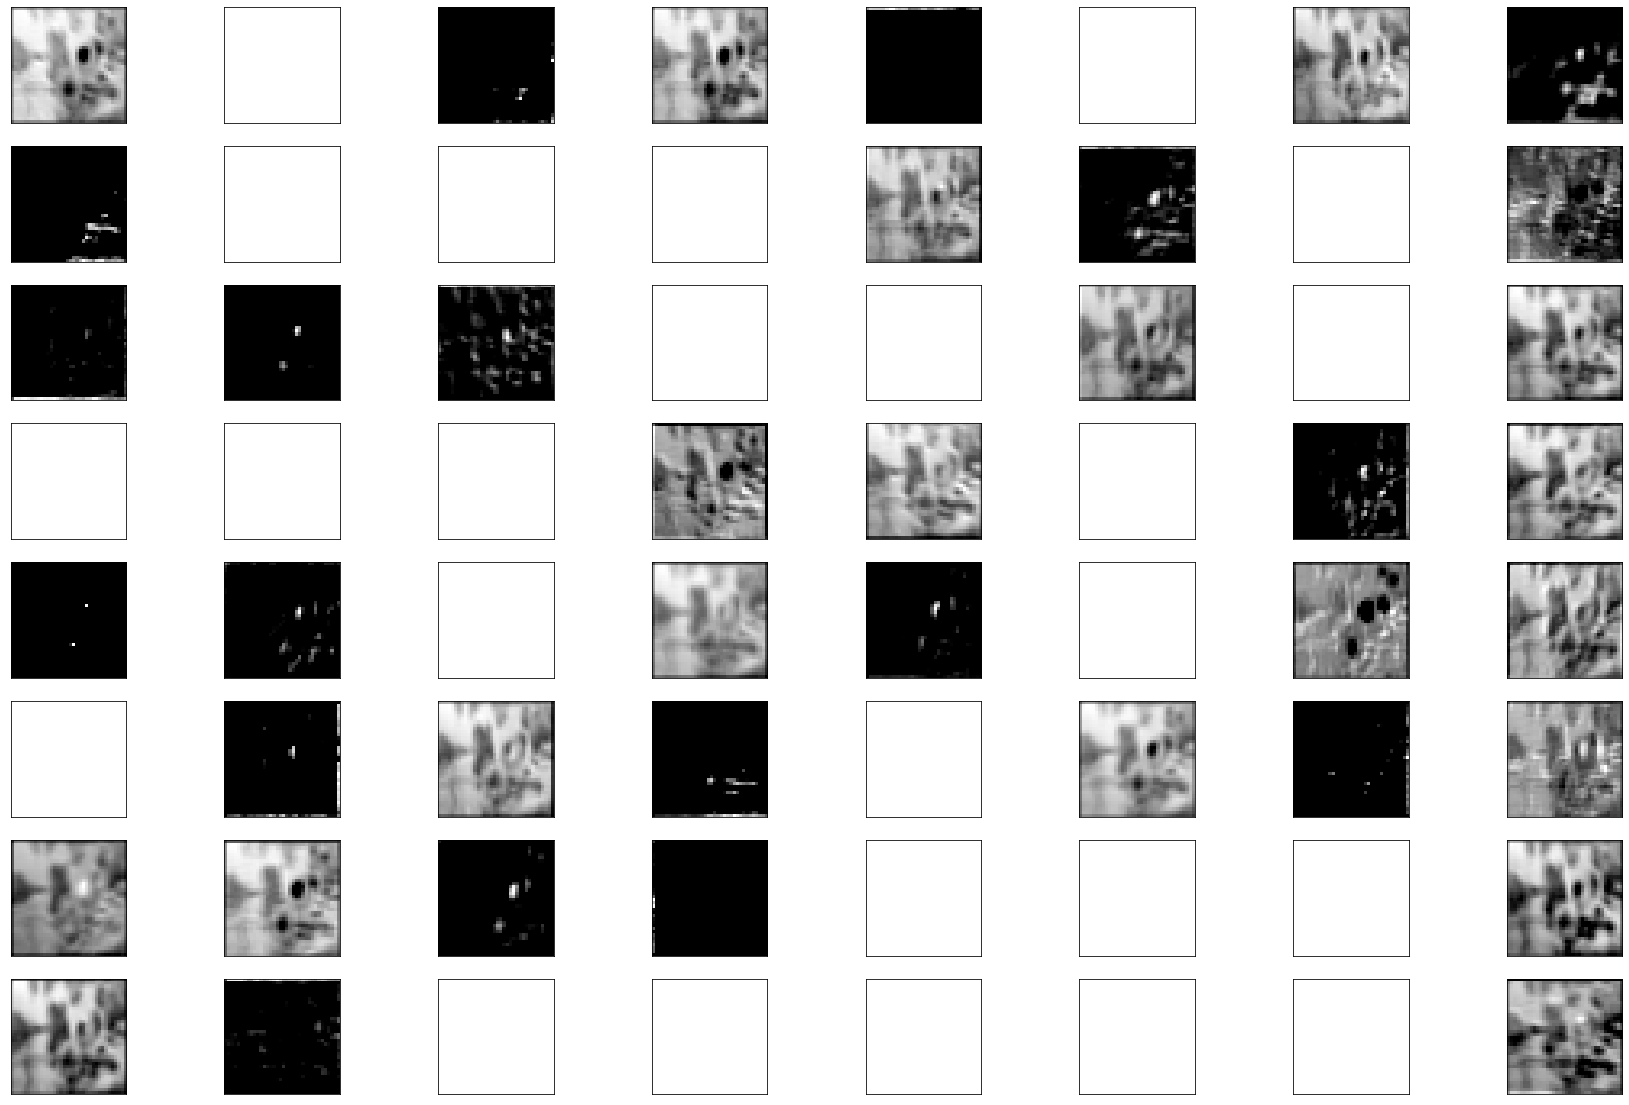

conv2d_67


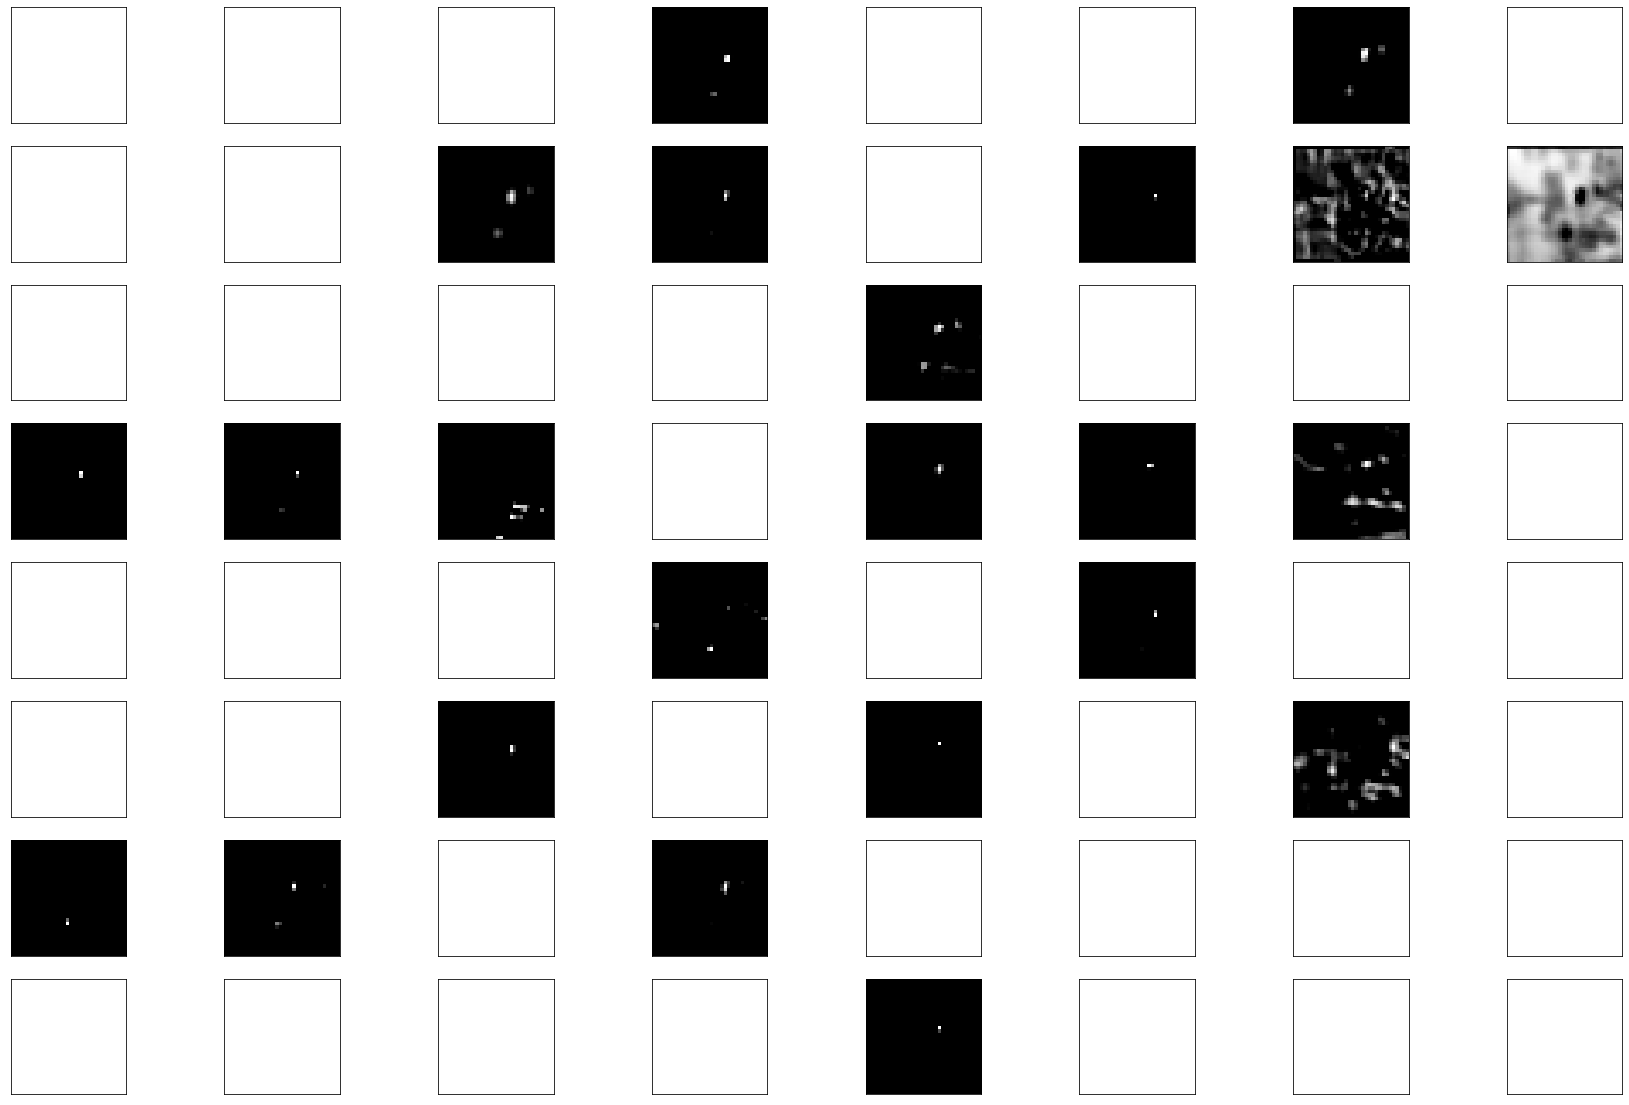

In [76]:
example = np_train_dataset[0][0]
feature_maps(model3, example)

In [74]:
# filters, biases = model.layers[2].get_weights()
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)

# plt.figure(figsize=(10, 10))
# # plot first few filters
# n_filters, ix = filters.shape[3], 1
# for i in range(n_filters):
#     # get the filter
#     f = filters[:, :, :, i]
#     # plot each channel separately
#     for j in range(3):
#         # specify subplot and turn of axis
#         ax = plt.subplot(n_filters, 3, ix)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         # plot filter channel in grayscale
#         plt.imshow(f[:, :, j], cmap='gray')
#         ix += 1

# #     ax = plt.subplot(n_filters, 3, ix)
# #     ax.set_xticks([])
# #     ax.set_yticks([])
# #     plt.imshow(f, cmap='gray')
# #     ix += 1
# # show the figure
# plt.show()

ValueError: too many values to unpack (expected 2)

# Training progress plotting

In [68]:
# from bokeh.plotting import figure, output_notebook, show

# p = figure(title="Training accuracy", y_range=(0,1),
#            background_fill_color="#fafafa")

# p.line(list(range(len(history.history['accuracy']))), history.history['accuracy'],
#        legend_label="training accuracy",
#        line_color="blue")

# p.line(list(range(len(history.history['val_accuracy']))), history.history['val_accuracy'],
#        legend_label="validation accuracy",
#        line_color="red")

# p.legend.location = "top_left"

# output_notebook()

# show(p)

Loading BokehJS ...

In [69]:
# from bokeh.plotting import figure, output_notebook, show

# p = figure(title="Training loss",
#            background_fill_color="#fafafa")

# p.line(list(range(len(history.history['loss']))), history.history['loss'],
#        legend_label="training loss",
#        line_color="blue")

# p.line(list(range(len(history.history['val_loss']))), history.history['val_loss'],
#        legend_label="validation loss",
#        line_color="red")

# p.legend.location = "top_left"

# output_notebook()

# show(p)

Loading BokehJS ...

# Conclusions

Dataset: monkeys - 10 classes. Continous augmentation has been applied. There ar batches of size 64.

Three models has been trained. First of them achived near 75& accuraccy after ~1000 epoches (not visible in output cell because of multiple rerun). It uses dropout, batch normalization and regularization L2. Second model uses no dropout at all and much less L2 regularization (0.001 vs 0.03). It also uses adam optimizer instead of SGD with momentum. It learns faster but it also overfit faster, so there were no difference from efficiency point of view.

Last, third, model has fine tuned hyperparameters: no regularization L2, dropout=0.25, no batch normalization. I has very quickly (~20 epochs) achieved 75% accuraccy and then it starts oscillate near it. Finally it achieves 83%. Maybe longer training could improve accuraccy to 85-90%.

Monkeys dataset has 10 classes so it is much harder than binary classification so this performance is quite good.

Feature maps analysis of all 3 models shows that a lot of kernels seems to do nothing (some of the feature maps are totally white or black)